In [1]:
# please set a transformation value between 5 to 25
angle = 5

keypoints_left:
769
keypoints_front:
790
keypoints_right:
777


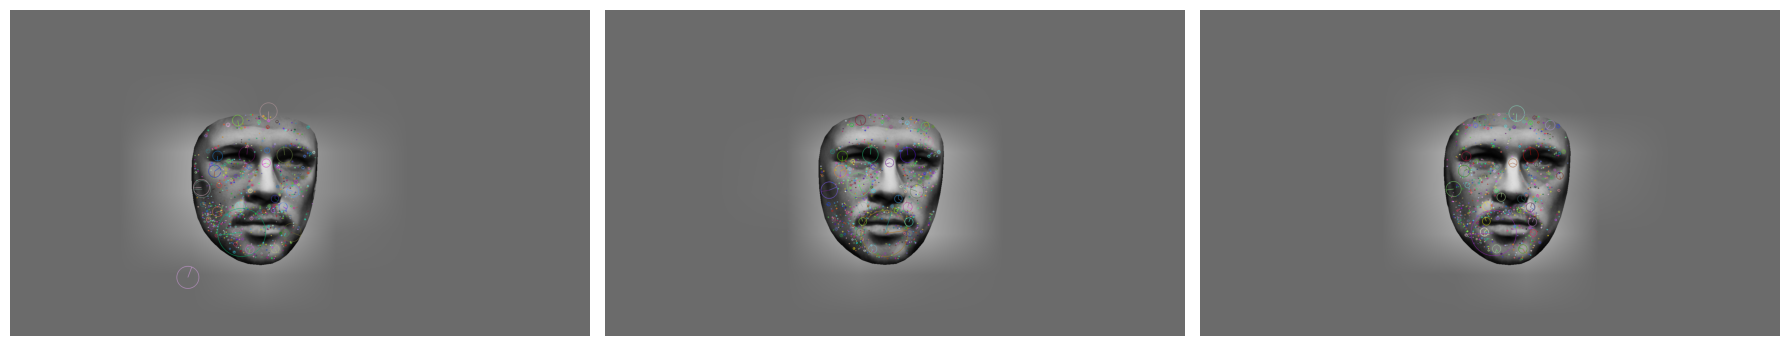

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import json


img_left = cv.imread(f"brad_{angle}/purple_left.png", cv.IMREAD_GRAYSCALE)
img_front = cv.imread(f"brad_{angle}/purple_front.png", cv.IMREAD_GRAYSCALE)
img_right = cv.imread(f"brad_{angle}/purple_right.png", cv.IMREAD_GRAYSCALE)

# apply theCLAHE alggorithm to the images
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_left = clahe.apply(img_left)
img_front = clahe.apply(img_front)
img_right = clahe.apply(img_right)


# a function to find correspondences between two scenes, the scenes' keypoints and descriptors are from a feature detection function
def match_features(des1, kp1, des2, kp2):
    matcher = cv.BFMatcher()

    # find matches using KNN
    matches = matcher.knnMatch(des1, des2, k=2)

    valid_matches = [m for m, n in matches if m.distance < 0.85 * n.distance]
    pts1 = np.float32([kp1[m.queryIdx].pt for m in valid_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in valid_matches])

    # calculate the fundamental matrix with the mask to filter the keypoints
    F, mask = cv.findFundamentalMat(
        pts1,
        pts2,
        cv.FM_RANSAC,
        ransacReprojThreshold=2.0,  # it is known that maximum allowed reprojection error
        confidence=0.99,  # a probability of the estimated matrix is correct
    )

    return pts1[mask.ravel() == 1], pts2[mask.ravel() == 1], F


# a function to draw the epipolar lines between two images
def draw_epipolar_lines(image1, image2, lines, pts1, pts2):
    rows, cols = image1.shape
    # convert the images to colour for the epipolar lines
    img1_col = cv.cvtColor(image1, cv.COLOR_GRAY2BGR)
    img2_col = cv.cvtColor(image2, cv.COLOR_GRAY2BGR)

    for line, pt1, pt2 in zip(lines, pts1, pts2):
        colour = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -line[2] / line[1]])
        x1, y1 = map(int, [cols, -(line[2] + line[0] * cols) / line[1]])
        img1_col = cv.line(img1_col, (x0, y0), (x1, y1), colour, 1)
        img1_col = cv.circle(img1_col, tuple(pt1), 5, colour, -1)
        img2_col = cv.circle(img2_col, tuple(pt2), 5, colour, -1)
    return img1_col, img2_col


# a function to detect features using SIFT
def extract_features(image):
    sift = cv.SIFT_create(
        nfeatures=0,  # 0 is for the unlimited number of features
        nOctaveLayers=3,  # the number of layers per octave in the scale space
        contrastThreshold=0.01,  # lower threshold makes weaker features
        edgeThreshold=5,  # threshold for edges
        sigma=1.56,  # gaussian sigma for blur before DoG pyramid
    )
    return sift.detectAndCompute(image, None)


# compute keypoints and descriptors for each scene
keypoints_left, descriptors_left = extract_features(img_left)
keypoints_front, descriptors_front = extract_features(img_front)
keypoints_right, descriptors_right = extract_features(img_right)

print("keypoints_left:")
print(len(keypoints_left))
print("keypoints_front:")
print(len(keypoints_front))
print("keypoints_right:")
print(len(keypoints_right))

# draw keypoints for each scene
img_left_kp = cv.drawKeypoints(
    img_left, keypoints_left, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
img_front_kp = cv.drawKeypoints(
    img_front, keypoints_front, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
img_right_kp = cv.drawKeypoints(
    img_right, keypoints_right, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(cv.cvtColor(img_left_kp, cv.COLOR_BGR2RGB))
axs[0].axis("off")

axs[1].imshow(cv.cvtColor(img_front_kp, cv.COLOR_BGR2RGB))
axs[1].axis("off")

axs[2].imshow(cv.cvtColor(img_right_kp, cv.COLOR_BGR2RGB))
axs[2].axis("off")

plt.tight_layout()
plt.show()

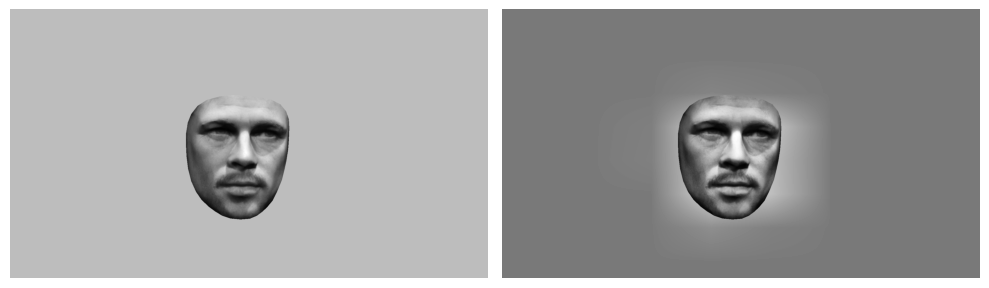

In [3]:
# a code to explain differents between the original and applied CLAHE images

img_front_original = cv.imread(f"brad_{angle}/purple_front.png", cv.IMREAD_GRAYSCALE)

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_front_clahe = clahe.apply(img_front_original)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_front_original, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_front_clahe, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

Fundamental matrix (left-front):
[[-9.35518119e-09  1.70707123e-05 -8.86678792e-03]
 [-1.67512498e-05  5.40429119e-08  2.60919008e-03]
 [ 8.70970554e-03 -4.56443210e-03  1.00000000e+00]]
The number of correspondences (left-front):
(432, 2)


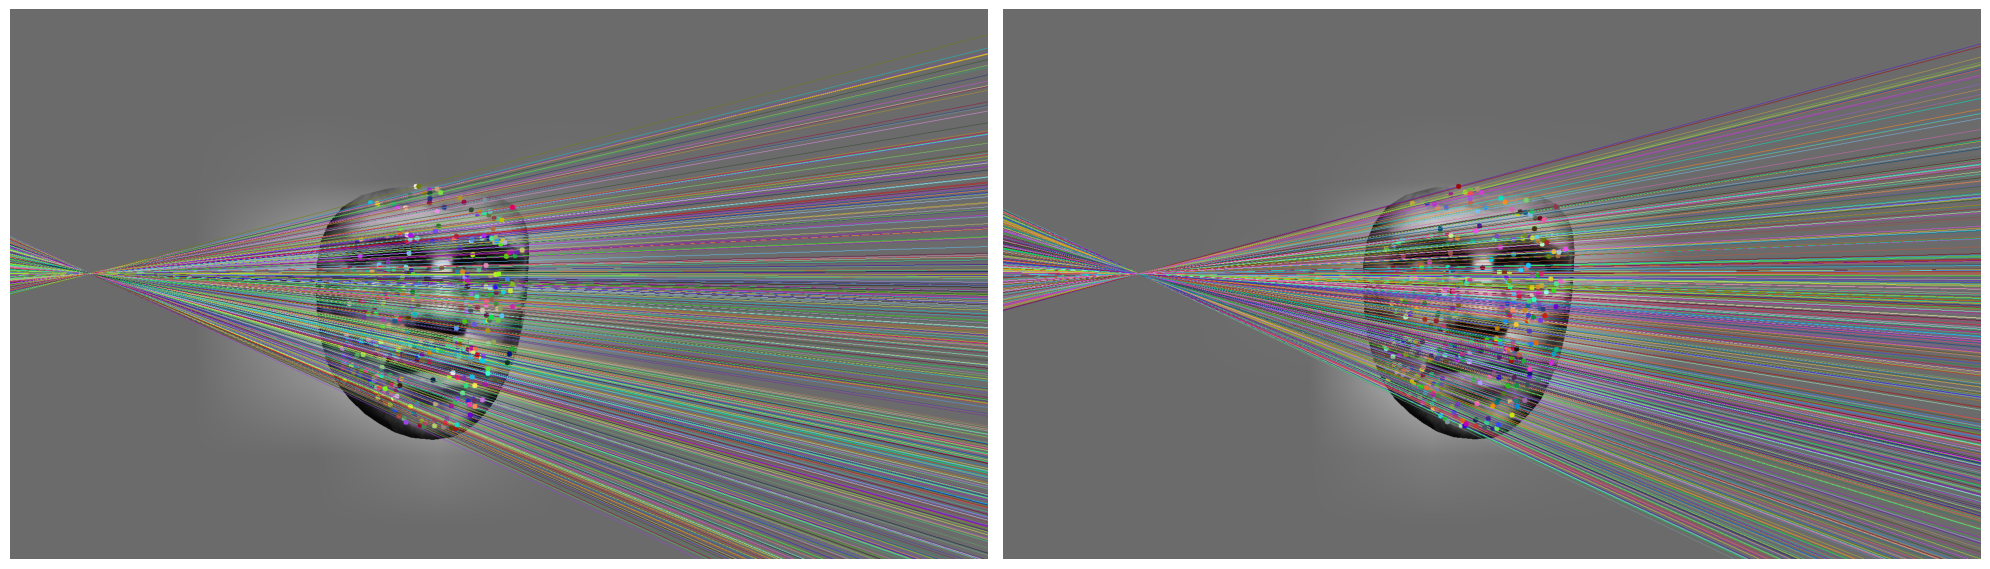

In [4]:
# get correspondences with its fundamental matrix
matched_points_left, matched_points_front_L, F = match_features(
    descriptors_left, keypoints_left, descriptors_front, keypoints_front
)

print("Fundamental matrix (left-front):")
print(F)
print("The number of correspondences (left-front):")
print(matched_points_front_L.shape)


# computer epipolar lines with the fundamental matrix
epilines_on_left = cv.computeCorrespondEpilines(
    matched_points_front_L.reshape(-1, 1, 2), 2, F
).reshape(-1, 3)
epilines_on_front = cv.computeCorrespondEpilines(
    matched_points_left.reshape(-1, 1, 2), 1, F
).reshape(-1, 3)

inlier_left_pts_int = [tuple(map(int, pt)) for pt in matched_points_left]
inlier_front_pts_int = [tuple(map(int, pt)) for pt in matched_points_front_L]

# draw epipolar lines between the two pairs
img_left_epilines, img_front_points = draw_epipolar_lines(
    img_left, img_front, epilines_on_left, inlier_left_pts_int, inlier_front_pts_int
)
img_front_epilines, img_left_points = draw_epipolar_lines(
    img_front, img_left, epilines_on_front, inlier_front_pts_int, inlier_left_pts_int
)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(cv.cvtColor(img_left_epilines, cv.COLOR_BGR2RGB))

plt.axis("off")
plt.subplot(122)
plt.imshow(cv.cvtColor(img_front_epilines, cv.COLOR_BGR2RGB))

plt.axis("off")
plt.tight_layout()
plt.show()

Fundamental matrix (left-front):
[[ 1.19952235e-07  1.33510373e-05 -1.00079592e-02]
 [-1.35795470e-05  3.10031856e-08  2.20714920e-02]
 [ 9.85648766e-03 -2.31797869e-02  1.00000000e+00]]
The number of correspondences (left-front):
(442, 2)


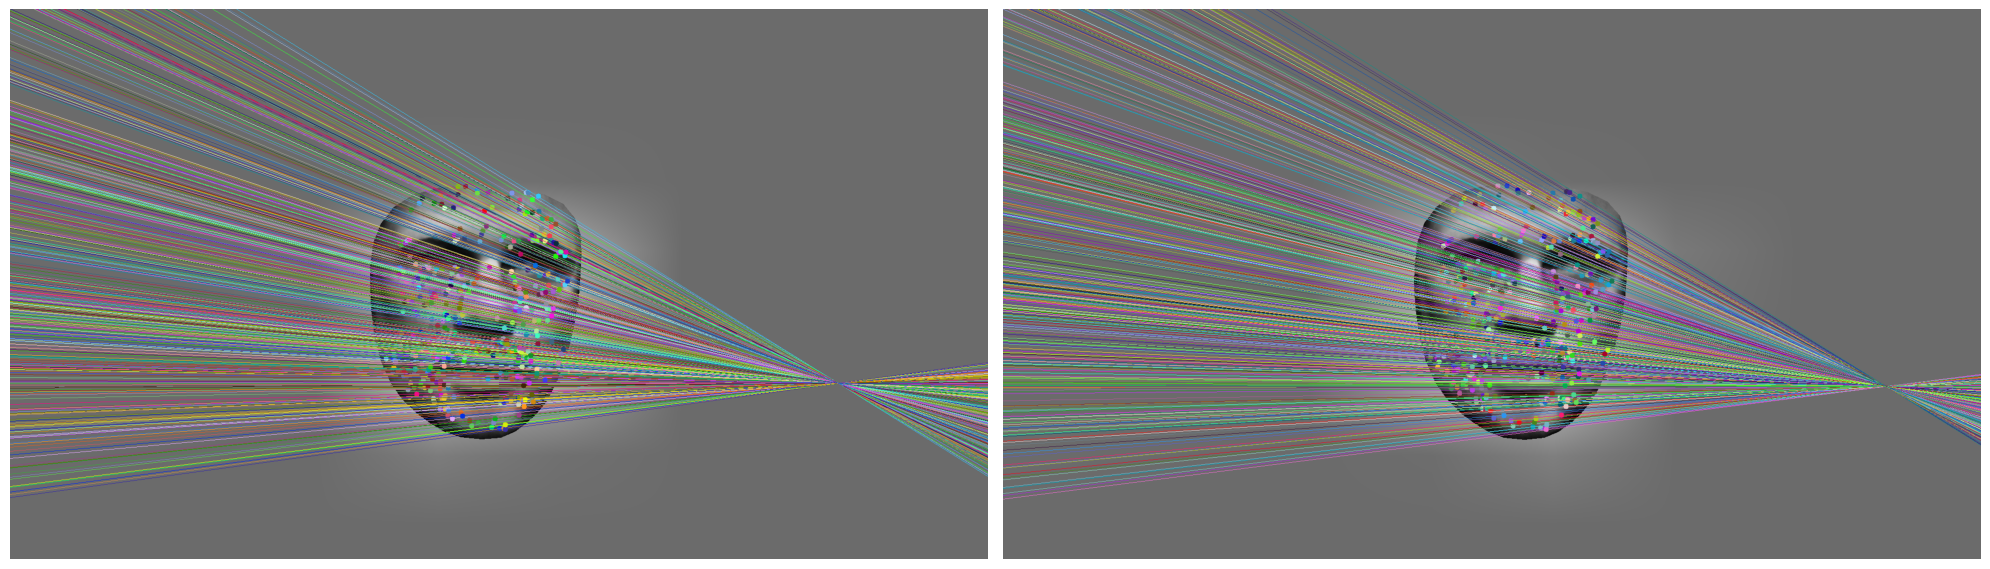

In [5]:
# the same process again from the previous


matched_points_front_R, matched_points_right, F = match_features(
    descriptors_front, keypoints_front, descriptors_right, keypoints_right
)

print("Fundamental matrix (left-front):")
print(F)
print("The number of correspondences (left-front):")
print(matched_points_front_R.shape)


epilines_on_front = cv.computeCorrespondEpilines(
    matched_points_right.reshape(-1, 1, 2), 2, F
).reshape(-1, 3)
epilines_on_right = cv.computeCorrespondEpilines(
    matched_points_front_R.reshape(-1, 1, 2), 1, F
).reshape(-1, 3)

inlier_front_pts_int = [tuple(map(int, pt)) for pt in matched_points_front_R]
inlier_right_pts_int = [tuple(map(int, pt)) for pt in matched_points_right]

img_front_epilines, img_right_points = draw_epipolar_lines(
    img_front, img_right, epilines_on_front, inlier_front_pts_int, inlier_right_pts_int
)
img_right_epilines, img_front_points = draw_epipolar_lines(
    img_right, img_front, epilines_on_right, inlier_right_pts_int, inlier_front_pts_int
)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(cv.cvtColor(img_front_epilines, cv.COLOR_BGR2RGB))

plt.axis("off")

plt.subplot(122)
plt.imshow(cv.cvtColor(img_right_epilines, cv.COLOR_BGR2RGB))

plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# this code brings the camera parameters which extracted by Blender
with open(f"rotation_{angle}/camera_parameters.json", "r") as file:
    camera_parameters = json.load(file)


def get_camera_parameters(name):
    return next(cam for cam in camera_parameters if cam["name"] == name)


params_left = get_camera_parameters("camera_left")
params_front = get_camera_parameters("camera_front")
params_right = get_camera_parameters("camera_right")

# Blender camera values:
focal_length_mm = 50
sensor_width_mm = 36
sensor_height_mm = 20.25
image_width_px = 1920
image_height_px = 1080

fx = (focal_length_mm / sensor_width_mm) * image_width_px
fy = (focal_length_mm / sensor_height_mm) * image_height_px
cx = image_width_px / 2
cy = image_height_px / 2

K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
print("Intrinsic matrix:\n", K)


# a function for extracting extrinsic values
def get_RT(cam):
    R = np.array(cam["rotation_world"])  # 3x3
    T = np.array(cam["translation_world"]).reshape(3, 1)  # 3x1
    return R, T


# convert world space to the front camera space
def get_relative_RT(R_cam, T_cam, R_ref, T_ref):
    R_rel = R_ref.T @ R_cam
    T_rel = R_ref.T @ (T_cam - T_ref)
    return R_rel, T_rel


R_front, T_front = get_RT(params_front)
R_left, T_left = get_RT(params_left)
R_right, T_right = get_RT(params_right)

R_front_rel = np.eye(3)
T_front_rel = np.zeros((3, 1))

R_left_rel, T_left_rel = get_relative_RT(R_left, T_left, R_front, T_front)
R_right_rel, T_right_rel = get_relative_RT(R_right, T_right, R_front, T_front)

# compute the projection matrices
proj_front = K @ np.hstack((R_front_rel, T_front_rel))
proj_left = K @ np.hstack((R_left_rel, T_left_rel))
proj_right = K @ np.hstack((R_right_rel, T_right_rel))
# print(proj_front)

# transpose correspondences for triangulation
points_front_L_T = matched_points_front_L.T
points_left_T = matched_points_left.T
points_front_R_T = matched_points_front_R.T
points_right_T = matched_points_right.T

# triangulate with homogeneous coordinates
homog_points_3d_LF = cv.triangulatePoints(
    proj_front, proj_left, points_front_L_T, points_left_T
)
points3d_LF = (homog_points_3d_LF[:3] / homog_points_3d_LF[3]).T
homog_points_3d_FR = cv.triangulatePoints(
    proj_front, proj_right, points_front_R_T, points_right_T
)
points3d_FR = (homog_points_3d_FR[:3] / homog_points_3d_FR[3]).T

# merge the 3D reconstructed point clouds
points3d_combined = np.vstack((points3d_LF, points3d_FR))
depth_mask = (points3d_combined[:, 2] < -0.94) & (points3d_combined[:, 2] > -1.0)
points3d_filtered_depth = points3d_combined[depth_mask]

print("Before filtering:")
print(points3d_combined.shape)
print("After filtering:")
print(points3d_filtered_depth.shape)

Intrinsic matrix:
 [[2.66666667e+03 0.00000000e+00 9.60000000e+02]
 [0.00000000e+00 2.66666667e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Before filtering:
(874, 3)
After filtering:
(858, 3)


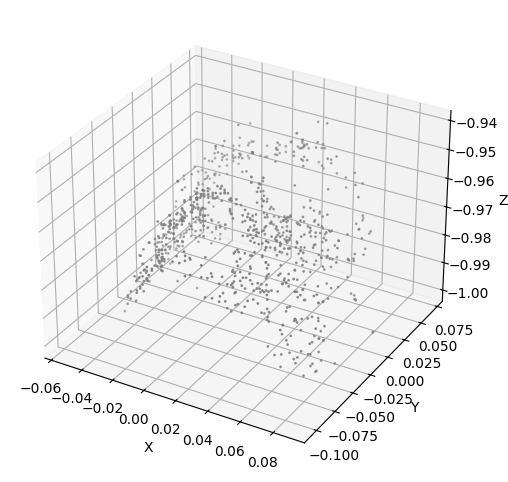

In [7]:
# %matplotlib qt

import matplotlib.pyplot as plt

# plot the filtered point cloud
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    points3d_filtered_depth[:, 0],
    points3d_filtered_depth[:, 1],
    points3d_filtered_depth[:, 2],
    s=1,
    c="gray",
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

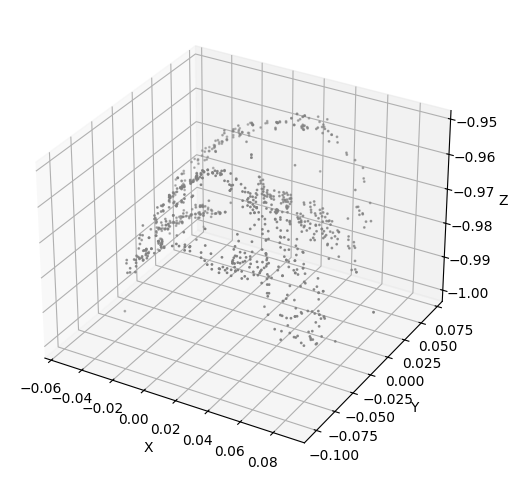

In [8]:
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt

# 2 cm: I determined this by manual testing
radius = 0.02

points_smoothed = points3d_filtered_depth.copy()

# run the smoothing function
tree = cKDTree(points_smoothed)

points_temp = points_smoothed.copy()
for i, pt in enumerate(points_smoothed):
    idx = tree.query_ball_point(pt, radius)
    neighbors = points_smoothed[idx]
    mean_z = neighbors[:, 2].mean()
    points_temp[i, 2] = mean_z  # smooth only the depth which is z
points_smoothed = points_temp
tree = cKDTree(points_smoothed)

points3d_smooth = points_smoothed

# plot the filtered and smoothed point cloud
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    points3d_smooth[:, 0], points3d_smooth[:, 1], points3d_smooth[:, 2], s=1, c="gray"
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [9]:
import numpy as np
import cv2 as cv
import trimesh
from scipy.spatial import Delaunay
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

texture_bgr = cv.imread(f"brad_{angle}/purple_front.png")
texture_rgb = cv.cvtColor(texture_bgr, cv.COLOR_BGR2RGB)


# a function to generate a final GLB file
def create_textured_mesh(points_3d, proj_matrix, image_rgb, img_front, output_path):
    img_height, img_width = img_front.shape[:2]

    # make the 3d point cloud into 2D for the texture map
    points_3d_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    projected_2d_h = (proj_matrix @ points_3d_h.T).T
    projected_2d = projected_2d_h[:, :2] / projected_2d_h[:, 2:3]
    in_bounds = (
        (projected_2d[:, 0] >= 0)
        & (projected_2d[:, 0] < img_width)
        & (projected_2d[:, 1] >= 0)
        & (projected_2d[:, 1] < img_height)
    )
    projected_2d_valid = projected_2d[in_bounds]
    points_3d_valid = points_3d[in_bounds]

    # UV coordinates are used to normalise
    uv_coords = projected_2d_valid.copy()
    uv_coords[:, 0] /= img_width
    uv_coords[:, 1] = 1.0 - (uv_coords[:, 1] / img_height)

    # delaunay triangulation is applied
    mesh_faces = Delaunay(projected_2d_valid).simplices

    rotated_vertices = points_3d_valid @ np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]]).T

    # to open the file in Blender with a right position, this transformation was required
    transform = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])
    rotated_vertices = rotated_vertices @ transform.T
    rotated_vertices[:, 2] += 1

    # create the texture image
    texture_pil = Image.fromarray(image_rgb)

    # Create texture mesh
    mesh = trimesh.Trimesh(vertices=rotated_vertices, faces=mesh_faces, process=False)
    mesh.visual = trimesh.visual.texture.TextureVisuals(uv=uv_coords, image=texture_pil)

    # save as GLB
    scene = trimesh.Scene(mesh)
    glb_data = scene.export(file_type="glb")
    with open(output_path, "wb") as f:
        f.write(glb_data)

    # plot the texture map
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)

    uv_x = uv_coords[:, 0] * img_width
    uv_y = img_height - (uv_coords[:, 1] * img_height)

    triang = mtri.Triangulation(uv_x, uv_y, triangles=mesh_faces)
    plt.triplot(triang, color="red", linewidth=0.5)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

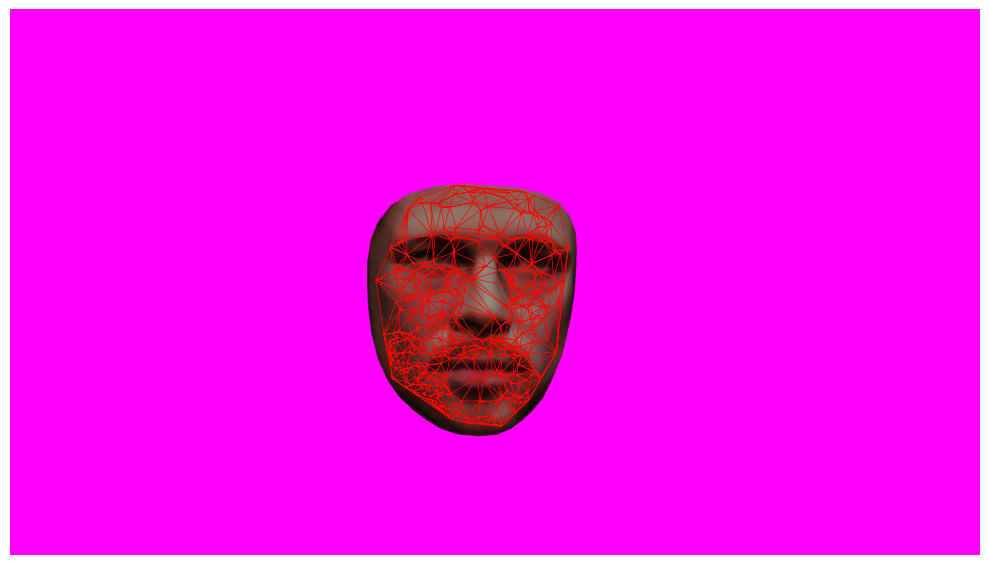

In [10]:
# create the GLB file for the original output
create_textured_mesh(
    points3d_filtered_depth,
    proj_front,
    texture_rgb,
    img_front,
    f"brad_{angle}/original_output.glb",
)

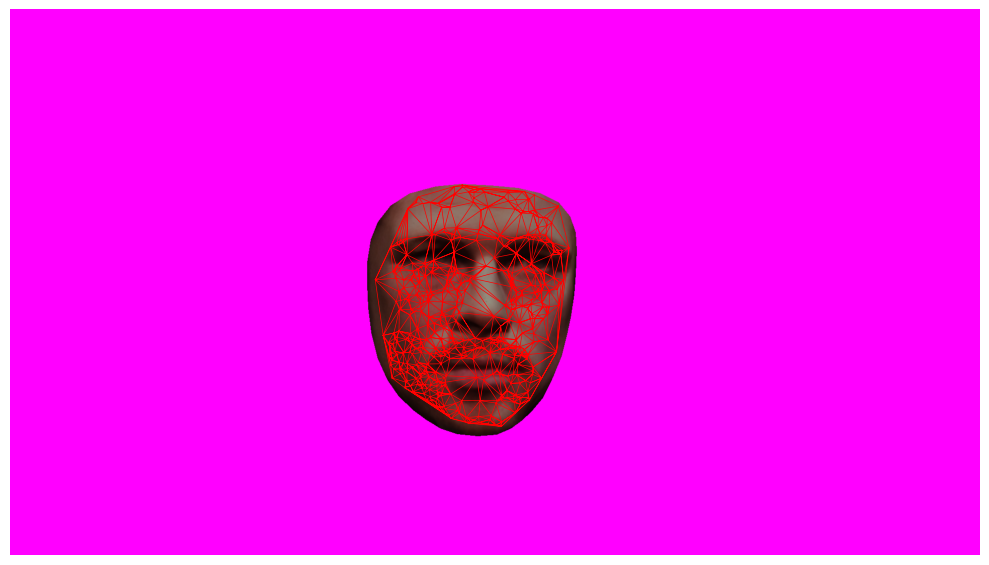

In [11]:
# create the GLB file for the smoothed output
create_textured_mesh(
    points3d_smooth,
    proj_front,
    texture_rgb,
    img_front,
    f"brad_{angle}/smoothed_output.glb",
)